In [1]:
import numpy as np
import pandas as pd
import tsfresh as ts
from sklearn import preprocessing
from tqdm import tqdm
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection, SelectBySingleFeaturePerformance
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
fe = []
lablist = []
for sj in range(2, 16):
    csv_file_path = f'./steps_data_new/sj{sj}.csv'
    df = pd.read_csv(csv_file_path)
    df = df[~df['Speed'].str.contains('warm_up')]
    df = df[~df['Speed'].str.contains('cool_down')]
    labels = df.groupby('Step')['Incline'].apply(list)
    labels = [sublist[0] for sublist in labels]
    l2 = preprocessing.LabelEncoder()
    l2.fit(labels)
    labs = l2.transform(labels)
    lablist.append(labs)
    le = preprocessing.LabelEncoder()
    le.fit(df.Step)
    df['Step'] = le.transform(df.Step)
    df = df.drop(columns = ['Unnamed: 0', 'Forefoot', 'Midfoot', 'Heel', 'Total', 'AT_loading', 'Speed', 'Incline', 'Combined'])
    extracted_features = ts.extract_features(df, column_id = 'Step', column_sort = 'Time')
    fe.append(extracted_features)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.33it/s]


In [3]:
fe_2 = []

for i in tqdm(range(len(fe))):
    rem = []
    X_ = fe[i]
    for j in range(X_.columns.shape[0]):
        num_class = np.unique(X_.iloc[:,j]).shape[0]
        if num_class <= 2 or np.where(X_.iloc[:,j].isna())[0].shape[0] != 0 or np.sum(np.isinf(X_.iloc[:,j])) > 0:
            rem.append(X_.columns[j])
    new_feat = X_.drop(columns = rem)
    fe_2.append(new_feat)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.92it/s]


In [4]:
fe_3 = []
kfold = KFold(n_splits=5, random_state=0, shuffle = True)
for i in tqdm(range(len(fe_2))):
    X = fe_2[i]
    Y = lablist[i]
    tr = []
    tr = SmartCorrelatedSelection()
    X2 = tr.fit_transform(X, Y)
    fe_3.append(X2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.21s/it]


In [5]:
acc_list = []
f_list = []
d_list = []
b_list = []
c_list = []
for i in tqdm(range(len(fe_3))):
    clf = SVC(random_state = 0)
    #clf = RandomForestClassifier(n_estimators = 200, random_state = 0)
    T = SelectBySingleFeaturePerformance(estimator = clf, threshold = 0.01, scoring = 'accuracy', cv = 5)
    x = fe_3[i]
    y = lablist[i]
    model = T.fit(x, y = y)
    dic = model.feature_performance_
    keys = list(dic.values())
    order = np.argsort(np.array(keys))[::-1]
    idx = order[0]
    feat_set = [idx]
    acc = [keys[idx]]
    best = 0
    for i in range(len(keys)):
        feat_set.append(order[i])
        temp = x.iloc[:,feat_set]
        y_pred = cross_val_predict(clf, temp, y, cv = kfold)
        cv_score = accuracy_score(y_pred, y)
        cm_matrix = confusion_matrix(y_pred, y)
        if cv_score > best:
            best_data = temp.copy()
            best_vars = np.array(list(dic))[feat_set]
            best_cm = cm_matrix
            best = cv_score
        acc.append(cv_score)
    acc_list.append(acc)
    b_list.append(best)
    f_list.append(best_vars)
    d_list.append(best_data)
    c_list.append(best_cm)
print(b_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [10:41<00:00, 45.80s/it]

[0.39145299145299145, 0.506006006006006, 0.4755784061696658, 0.40481927710843374, 0.38589211618257263, 0.44990892531876137, 0.39783001808318263, 0.4097087378640777, 0.35139573070607555, 0.4458955223880597, 0.32612966601178783, 0.4837476099426386, 0.4369369369369369, 0.5854700854700855]


0.43219800211723397 0.4233228374005073


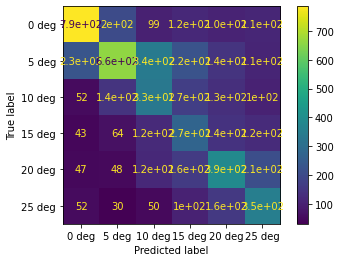

In [7]:
print(np.mean(b_list), np.median(b_list))
c_matrix_total = np.zeros(c_list[0].shape)

for i in range(len(c_list)):
    c_matrix_total += c_list[i]
    
    
cm = pd.DataFrame(c_matrix_total)
cm.to_csv('CM_Inc_SVM.csv', index = False)


disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix_total, display_labels = ["0 deg", "5 deg", "10 deg", "15 deg", "20 deg", "25 deg"])

disp.plot()


plt.show()

In [6]:
np.median(b_list), np.mean(b_list)

(0.4207908557306148, 0.4320824539318174)

In [1]:
import numpy as np

np.std(np.array([0.39145299145299145, 0.506006006006006, 0.4755784061696658, 0.40481927710843374, 0.38589211618257263, 0.44990892531876137, 0.39783001808318263, 0.4097087378640777, 0.35139573070607555, 0.4458955223880597, 0.32612966601178783, 0.4837476099426386, 0.4369369369369369, 0.5854700854700855]
))

0.06437798022696187